# Predicting Home Loans' Repayment and Analysis of Unbanked Population

The unbanked population, consumers without adequate credit history, will go to an untrustworthy lender who could take unfair advantage of their situation because reputable banks will not provide them with loans. The subprime loans have caused enough damage to our economic system, so our task is to help identify worthy candidates 


However, there could be other ways to determine the credit worthiness of applicants. The vision of Home Credit Group is to provide fair and equal services to a non-traditional home loan applicant. 


1) Determine if the applicant will likely repay their loan by using previous credit information via the Home Credit Group's databases and the Credit Bureau

2) Find non-traditional methods to determine the credit worthiness of an applicant (unbanked

In [1]:
import pandas as pd
import numpy as np
import pickle

#Allows to see up to 500 columns within notebook
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('display.width',1000)

# Load datasets into dataframes

In [2]:
df_application_train = pd.read_csv('application_train.csv',header=0,error_bad_lines=False,nrows=50000)
df_previous_application = pd.read_csv('previous_application.csv',header=0,error_bad_lines=False)
df_installment_payments = pd.read_csv('installments_payments.csv',header=0,error_bad_lines=False)
df_bureau = pd.read_csv('bureau.csv',header=0,error_bad_lines=False)

#I do not use the following datasets within this notebook. However, it could be useful at a later time.
#df_bureau_bal = pd.read_csv('bureau_balance.csv',header=0,error_bad_lines=False,nrows=5000)
#df_pos_cash_bal = pd.read_csv('POS_CASH_balance.csv',header=0,error_bad_lines=False,nrows=5000)
#df_credit_card_bal = pd.read_csv('credit_card_balance.csv',header=0,error_bad_lines=False,nrows=5000)

#dflist = [df_application_train,df_previous_application,df_installment_payments,df_bureau,df_bureau_bal,df_pos_cash_bal,df_credit_card_bal]


In [3]:
#Drop Data for Application IDs not included within application train dataset

df_previous_application['TARGET APPS'] = df_previous_application.SK_ID_CURR.isin(df_application_train.SK_ID_CURR)
df_installment_payments['TARGET APPS'] = df_installment_payments.SK_ID_CURR.isin(df_application_train.SK_ID_CURR)
df_bureau['TARGET APPS'] = df_bureau.SK_ID_CURR.isin(df_application_train.SK_ID_CURR)


df_previous_application_new = df_previous_application[df_previous_application['TARGET APPS']==True]
df_installment_payments_new = df_installment_payments[df_installment_payments['TARGET APPS']==True]
df_bureau_new = df_bureau[df_bureau['TARGET APPS']==True]

In [4]:
series = df_previous_application_new.SK_ID_CURR.isin(df_application_train.SK_ID_CURR)
series.value_counts()

True    229287
Name: SK_ID_CURR, dtype: int64

# Previous Application Dataset

Started with Previous Application Dataset because it had historical information about the applicant and the mortgage lender's previous decision, so I believe it is extremely important. 

In [5]:
df_previous_application_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229287 entries, 1 to 1670202
Data columns (total 38 columns):
SK_ID_PREV                     229287 non-null int64
SK_ID_CURR                     229287 non-null int64
NAME_CONTRACT_TYPE             229287 non-null object
AMT_ANNUITY                    179486 non-null float64
AMT_APPLICATION                229287 non-null float64
AMT_CREDIT                     229287 non-null float64
AMT_DOWN_PAYMENT               107788 non-null float64
AMT_GOODS_PRICE                177634 non-null float64
WEEKDAY_APPR_PROCESS_START     229287 non-null object
HOUR_APPR_PROCESS_START        229287 non-null int64
FLAG_LAST_APPL_PER_CONTRACT    229287 non-null object
NFLAG_LAST_APPL_IN_DAY         229287 non-null int64
RATE_DOWN_PAYMENT              107788 non-null float64
RATE_INTEREST_PRIMARY          758 non-null float64
RATE_INTEREST_PRIVILEGED       758 non-null float64
NAME_CASH_LOAN_PURPOSE         229287 non-null object
NAME_CONTRACT_STATUS      

# Cleaning Datasets

1. FLAG_LAST_APPL_PER_CONTRACT: If this column had the value of 'N', then it was more than likely a mistake or duplicate of another application. My thought is that this maybe unnecessary data to the purpose of this project.

2. AMT_APPLICATION: This column states how much the applicant has asked for from the bank. 

3. AMT_CREDIT: This column states how much the bank as credited the applicant.

My thought is if (2) and (3) are 0, then the application is incomplete and it would not provide me with additional information about the application. Thus I should remove these rows from my dataset.
        

In [6]:

# Function to calculate missing values by columns


def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns.sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1]>0].shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
    
  

In [7]:
def aggfuncdic(df):
    dictionary = {}

    for i in df.columns:
        if df[i].dtype == 'object':
            dictionary[i] = lambda x: len(x.unique())
        else:
            dictionary[i] = [min,max,np.mean,sum]
    return dictionary

def flatten_multilevel_col(df):
    new_cols = [''.join(t) for t in df.columns]
    df.columns = new_cols
    return df

In [8]:
missing_values = missing_values_table(df_previous_application_new)
nonmissingvallist = missing_values[missing_values.iloc[:,1]<80].index.tolist()
df_previous_application_new = df_previous_application_new[nonmissingvallist]

Your selected dataframe has 38 columns.
There are 14 columns that have missing values.


Previous application dataset has all of the previous application available. Currently, it has a 1:many relationship to the application dataset, so I will need to aggregate the columns before merging. Below is where I aggreagated the previous_application dataset by using index 'SK_ID_CURR'. The purpose of this is so I can provide a 1:1 relationship to the train/test dataset, while limit the columns created.

In [9]:

df_prevapp_pivot = pd.pivot_table(df_previous_application_new,values=df_previous_application_new.columns,index='SK_ID_CURR',
                                  aggfunc=aggfuncdic(df_previous_application_new))

In [10]:
missing_values_prev = missing_values_table(df_prevapp_pivot)
missing_values_train = missing_values_table(df_application_train)


Your selected dataframe has 96 columns.
There are 33 columns that have missing values.
Your selected dataframe has 122 columns.
There are 64 columns that have missing values.


In [11]:
flatten_multilevel_col(df_prevapp_pivot)


,AMT_ANNUITYmax,AMT_ANNUITYmean,AMT_ANNUITYmin,AMT_ANNUITYsum,AMT_APPLICATIONmax,AMT_APPLICATIONmean,AMT_APPLICATIONmin,AMT_APPLICATIONsum,AMT_CREDITmax,AMT_CREDITmean,AMT_CREDITmin,AMT_CREDITsum,AMT_DOWN_PAYMENTmax,AMT_DOWN_PAYMENTmean,AMT_DOWN_PAYMENTmin,AMT_DOWN_PAYMENTsum,AMT_GOODS_PRICEmax,AMT_GOODS_PRICEmean,AMT_GOODS_PRICEmin,AMT_GOODS_PRICEsum,CHANNEL_TYPE<lambda>,CNT_PAYMENTmax,CNT_PAYMENTmean,CNT_PAYMENTmin,CNT_PAYMENTsum,CODE_REJECT_REASON<lambda>,DAYS_DECISIONmax,DAYS_DECISIONmean,DAYS_DECISIONmin,DAYS_DECISIONsum,DAYS_FIRST_DRAWINGmax,DAYS_FIRST_DRAWINGmean,DAYS_FIRST_DRAWINGmin,DAYS_FIRST_DRAWINGsum,DAYS_FIRST_DUEmax,DAYS_FIRST_DUEmean,DAYS_FIRST_DUEmin,DAYS_FIRST_DUEsum,DAYS_LAST_DUEmax,DAYS_LAST_DUEmean,DAYS_LAST_DUEmin,DAYS_LAST_DUEsum,DAYS_LAST_DUE_1ST_VERSIONmax,DAYS_LAST_DUE_1ST_VERSIONmean,DAYS_LAST_DUE_1ST_VERSIONmin,DAYS_LAST_DUE_1ST_VERSIONsum,DAYS_TERMINATIONmax,DAYS_TERMINATIONmean,DAYS_TERMINATIONmin,DAYS_TERMINATIONsum,FLAG_LAST_APPL_PER_CONTRACT<lambda>,HOUR_APPR_PROCESS_STARTmax,HOUR_APPR_PROCESS_STARTmean,HOUR_APPR_PROCESS_STARTmin,HOUR_APPR_PROCESS_STARTsum,NAME_CASH_LOAN_PURPOSE<lambda>,NAME_CLIENT_TYPE<lambda>,NAME_CONTRACT_STATUS<lambda>,NAME_CONTRACT_TYPE<lambda>,NAME_GOODS_CATEGORY<lambda>,NAME_PAYMENT_TYPE<lambda>,NAME_PORTFOLIO<lambda>,NAME_PRODUCT_TYPE<lambda>,NAME_SELLER_INDUSTRY<lambda>,NAME_TYPE_SUITE<lambda>,NAME_YIELD_GROUP<lambda>,NFLAG_INSURED_ON_APPROVALmax,NFLAG_INSURED_ON_APPROVALmean,NFLAG_INSURED_ON_APPROVALmin,NFLAG_INSURED_ON_APPROVALsum,NFLAG_LAST_APPL_IN_DAYmax,NFLAG_LAST_APPL_IN_DAYmean,NFLAG_LAST_APPL_IN_DAYmin,NFLAG_LAST_APPL_IN_DAYsum,PRODUCT_COMBINATION<lambda>,RATE_DOWN_PAYMENTmax,RATE_DOWN_PAYMENTmean,RATE_DOWN_PAYMENTmin,RATE_DOWN_PAYMENTsum,SELLERPLACE_AREAmax,SELLERPLACE_AREAmean,SELLERPLACE_AREAmin,SELLERPLACE_AREAsum,SK_ID_CURRmax,SK_ID_CURRmean,SK_ID_CURRmin,SK_ID_CURRsum,SK_ID_PREVmax,SK_ID_PREVmean,SK_ID_PREVmin,SK_ID_PREVsum,TARGET APPSmax,TARGET APPSmean,TARGET APPSmin,TARGET APPSsum,WEEKDAY_APPR_PROCESS_START<lambda>
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,9251.775,9251.775000,9251.775,9251.775,179055.000,1.790550e+05,179055.000,1.790550e+05,179055.00,1.790550e+05,179055.000,1.790550e+05,0.000,0.000000,0.000,0.000,179055.000,1.790550e+05,179055.000,1.790550e+05,1,24.0,24.000000,24.0,24.0,1,-606,-606.000000,-606,-606,365243.0,365243.000000,365243.0,365243.0,-565.0,-565.000000,-565.0,-565.0,-25.0,-25.000000,-25.0,-25.0,125.0,125.000000,125.0,125.0,-17.0,-17.000000,-17.0,-17.0,1,9,9.000000,9,9,1,1,1,1,1,1,1,1,1,1,1,0.0,0.000000,0.0,0.0,1,1.000000,1,1,1,0.000000,0.000000,0.000000,0.000000,500,500.000000,500,500,100002,100002,100002,100002,1038818,1.038818e+06,1038818,1038818,True,True,True,1.0,1
100003,98356.995,56553.990000,6737.310,169661.970,900000.000,4.354365e+05,68809.500,1.306310e+06,1035882.00,4.841910e+05,68053.500,1.452573e+06,6885.000,3442.500000,0.000,6885.000,900000.000,4.354365e+05,68809.500,1.306310e+06,3,12.0,10.000000,6.0,30.0,1,-746,-1305.000000,-2341,-3915,365243.0,365243.000000,365243.0,1095729.0,-716.0,-1274.333333,-2310.0,-3823.0,-536.0,-1054.333333,-1980.0,-3163.0,-386.0,-1004.333333,-1980.0,-3013.0,-527.0,-1047.333333,-1976.0,-3142.0,1,17,14.666667,12,44,2,2,1,2,3,2,2,2,3,2,2,1.0,0.666667,0.0,2.0,1,1.000000,1,3,3,0.100061,0.050030,0.000000,0.100061,1400,533.000000,-1,1599,100003,100003,100003,300009,2636178,2.281150e+06,1810518,6843451,True,True,True,3.0,3
100004,5357.250,5357.250000,5357.250,5357.250,24282.000,2.428200e+04,24282.000,2.428200e+04,20106.00,2.010600e+04,20106.000,2.010600e+04,4860.000,4860.000000,4860.000,4860.000,24282.000,2.428200e+04,24282.000,2.428200e+04,1,4.0,4.000000,4.0,4.0,1,-815,-815.000000,-815,-815,365243.0,365243.000000,365243.0,365243.0,-784.0,-784.000000,-784.0,-784.0,-724.0,-724.000000,-724.0,-724.0,-694.0,-694.000000,-694.0,-694.0,-714.0,-714.000000,-714.0,-714.0,1,5,5.000000,5,5,1,1,1,1,1,1,1,1,1,1,1,0.0,0.000000,0.0,0.0,1,1.0000

# Merging previous_application dataset into application_train dataset 

In [12]:
df = df_application_train.merge(df_prevapp_pivot.reset_index(),on =['SK_ID_CURR'],suffixes=('_app_train','_prev_app'),how='left')

In [13]:
missing_values = missing_values_table(df)
missing_values


Your selected dataframe has 218 columns.
There are 160 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,34961,69.9
COMMONAREA_MODE,34961,69.9
COMMONAREA_AVG,34961,69.9
NONLIVINGAPARTMENTS_MEDI,34715,69.4
NONLIVINGAPARTMENTS_MODE,34715,69.4
NONLIVINGAPARTMENTS_AVG,34715,69.4
LIVINGAPARTMENTS_MODE,34227,68.5
LIVINGAPARTMENTS_AVG,34227,68.5
LIVINGAPARTMENTS_MEDI,34227,68.5
FONDKAPREMONT_MODE,34192,68.4


# Aggreagated Bureau & Installment datasets and then merged into dataset

In [14]:
missing_values = missing_values_table(df_bureau_new)
missing_values

Your selected dataframe has 18 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
AMT_ANNUITY,184062,77.3
AMT_CREDIT_MAX_OVERDUE,153901,64.6
DAYS_ENDDATE_FACT,88682,37.2
AMT_CREDIT_SUM_LIMIT,79832,33.5
AMT_CREDIT_SUM_DEBT,36708,15.4
DAYS_CREDIT_ENDDATE,14214,6.0
AMT_CREDIT_SUM,1,0.0
SK_ID_CURR,0,0.0
DAYS_CREDIT_UPDATE,0,0.0
CREDIT_TYPE,0,0.0


In [15]:
missing_values = missing_values_table(df_bureau_new)
nonmissingvallist = missing_values[missing_values.iloc[:,1]<80].index.tolist()
df_bureau_new = df_bureau_new[nonmissingvallist]

Your selected dataframe has 18 columns.
There are 6 columns that have missing values.


In [16]:
df_bureau_pivot = pd.pivot_table(df_bureau_new.reset_index(),values=df_bureau_new.columns,index='SK_ID_CURR',
                                 aggfunc=aggfuncdic(df_bureau_new))

In [17]:
flatten_multilevel_col(df_bureau_pivot)
df = df.merge(df_bureau_pivot.reset_index(),on =['SK_ID_CURR'],suffixes=('_curr','_bur'),how='left')

In [18]:
missing_values = missing_values_table(df_bureau_pivot)
missing_values

Your selected dataframe has 63 columns.
There are 18 columns that have missing values.


,Missing Values,% of Total Values
AMT_ANNUITYmax,29894,69.8
AMT_ANNUITYmin,29894,69.8
AMT_ANNUITYmean,29894,69.8
AMT_CREDIT_MAX_OVERDUEmax,12921,30.2
AMT_CREDIT_MAX_OVERDUEmean,12921,30.2
AMT_CREDIT_MAX_OVERDUEmin,12921,30.2
DAYS_ENDDATE_FACTmax,5337,12.5
DAYS_ENDDATE_FACTmean,5337,12.5
DAYS_ENDDATE_FACTmin,5337,12.5
AMT_CREDIT_SUM_LIMITmax,3472,8.1


In [19]:
print(df.info())
print(missing_values_table(df))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Columns: 281 entries, SK_ID_CURR to TARGET APPSsum_bur
dtypes: float64(218), int64(41), object(22)
memory usage: 107.6+ MB
None
Your selected dataframe has 281 columns.
There are 223 columns that have missing values.
                                     Missing Values  % of Total Values
AMT_ANNUITYmax_bur                            37043               74.1
AMT_ANNUITYmean_bur                           37043               74.1
AMT_ANNUITYmin_bur                            37043               74.1
COMMONAREA_MEDI                               34961               69.9
COMMONAREA_MODE                               34961               69.9
COMMONAREA_AVG                                34961               69.9
NONLIVINGAPARTMENTS_MEDI                      34715               69.4
NONLIVINGAPARTMENTS_MODE                      34715               69.4
NONLIVINGAPARTMENTS_AVG                       34715               69

# Aggregating and Merging Installment Payment Dataset

In addition, I created some additional columns: 
    1. AMT_INSTAL_PAY_DIFF: I believe that knowing how much the applicant has paid back in the past would be a 
        good indicator for the future

    2. NUM_INSTAL_VERSION_NUM_DIFF: I believe knowing how fast or slow the previous load was paid would also be 
        a good indicator.

    3. DAY_INSTAL_ENTRY_DIFF: Similar to NUM_INSTAL_VERSION_NUM_DIFF

In [20]:
df_installment_payments_new.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,TARGET APPS
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525,True
7,1818599,111420,2.0,4,-968.0,-994.0,17862.165,17862.165,True
8,2723183,112102,0.0,14,-197.0,-197.0,70.740,70.740,True
10,1782554,106597,1.0,3,-933.0,-937.0,34620.525,34620.525,True
11,2558880,154793,1.0,8,-1262.0,-1269.0,15031.080,15031.080,True


In [21]:
missing_values = missing_values_table(df_installment_payments_new)
missing_values

Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values
DAYS_ENTRY_PAYMENT,435,0.0
AMT_PAYMENT,435,0.0
SK_ID_PREV,0,0.0
SK_ID_CURR,0,0.0
NUM_INSTALMENT_VERSION,0,0.0
NUM_INSTALMENT_NUMBER,0,0.0
DAYS_INSTALMENT,0,0.0
AMT_INSTALMENT,0,0.0
TARGET APPS,0,0.0


In [22]:
missing_values = missing_values_table(df_installment_payments_new)
nonmissingvallist = missing_values[missing_values.iloc[:,1]<80].index.tolist()
df_installment_payments_new = df_installment_payments_new[nonmissingvallist]

Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


In [23]:
#Used Pivot Table to aggreate each column
df_installment_payments_pivot = pd.pivot_table(df_installment_payments_new,values=df_installment_payments_new.columns,index='SK_ID_CURR',
                                               aggfunc=aggfuncdic(df_installment_payments_new))                                                                                                                      

### Merged Installment Payments Pivoted Dataframe into main dataframe


In [24]:
flatten_multilevel_col(df_installment_payments_pivot)
df = df.merge(df_installment_payments_pivot.reset_index(),on =['SK_ID_CURR'],suffixes=('_curr2','_instpay'),how='left')

In [25]:
#Many current applicants do not have historical information. 
#Should test the differences between the 2 groups.

df['BANKED']= df.SK_ID_CURR.isin(df_bureau.SK_ID_CURR)
df['BANKED']=df.BANKED.map({True:1,False:0})

In [26]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Columns: 318 entries, SK_ID_CURR to BANKED
dtypes: float64(251), int64(42), object(25)
memory usage: 121.7+ MB
None


# Cleaning Up Missing Values/Null Values

In [27]:
missing_values = missing_values_table(df)
missing_values

Your selected dataframe has 318 columns.
There are 259 columns that have missing values.


,Missing Values,% of Total Values
AMT_ANNUITYmean_bur,37043,74.1
AMT_ANNUITYmax_bur,37043,74.1
AMT_ANNUITYmin_bur,37043,74.1
COMMONAREA_MEDI,34961,69.9
COMMONAREA_MODE,34961,69.9
COMMONAREA_AVG,34961,69.9
NONLIVINGAPARTMENTS_MODE,34715,69.4
NONLIVINGAPARTMENTS_MEDI,34715,69.4
NONLIVINGAPARTMENTS_AVG,34715,69.4
LIVINGAPARTMENTS_MEDI,34227,68.5


In [28]:
#Go to null value used throughout dataframe is 365243, so I decided to use it across the df
#df.fillna(value=0,inplace=True)
#df = df.replace(365423.000000,0.0)
#df = df.drop(df[df.AMT_INCOME_TOTAL>350000].index)

#df_nan = df.loc[:,df.columns.difference(['TARGET'])].replace(0.0,np.nan)
#df= pd.concat([df_nan,df.TARGET],axis=1)

df.DAYS_BIRTH = df.DAYS_BIRTH.apply(lambda x:x/-365)

In [29]:
missing_values = missing_values_table(df)
nonmissingvallist = missing_values[missing_values.iloc[:,1]<60].index.tolist()
missing_values

Your selected dataframe has 318 columns.
There are 259 columns that have missing values.


,Missing Values,% of Total Values
AMT_ANNUITYmean_bur,37043,74.1
AMT_ANNUITYmax_bur,37043,74.1
AMT_ANNUITYmin_bur,37043,74.1
COMMONAREA_MEDI,34961,69.9
COMMONAREA_MODE,34961,69.9
COMMONAREA_AVG,34961,69.9
NONLIVINGAPARTMENTS_MODE,34715,69.4
NONLIVINGAPARTMENTS_MEDI,34715,69.4
NONLIVINGAPARTMENTS_AVG,34715,69.4
LIVINGAPARTMENTS_MEDI,34227,68.5


In [30]:
len(df.describe().columns)

293

In [31]:
df = df[nonmissingvallist]
df = df.replace(np.nan,0.0)
len(df.describe().columns)

274

# Feature Elimination via SelectFromModel & LassoCV

I currently have 185 columns with 16 Categorical columns. I will need to cut the size of dataframe to prevent overfitting the models. I have used the SelectFromModel as the Meta-Transformer and LassoCV as the classifier. As a result, I have decreased my overall dataframe size by ~40%.  


In [32]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.linear_model import LassoCV

#Set index to SK_ID_CURR
df_ind = df.set_index('SK_ID_CURR')
df_dumb = pd.get_dummies(df_ind.select_dtypes('object'),dummy_na=True)
df_concat_dumb = pd.concat([df_ind.select_dtypes(exclude=['object']),df_dumb],axis=1)

df_concat_dumb.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 100002 to 157876
Columns: 456 entries, LANDAREA_MEDI to ORGANIZATION_TYPE_nan
dtypes: float64(233), int64(40), uint8(183)
memory usage: 113.2 MB


In [33]:
from sklearn.preprocessing import MinMaxScaler
df_test = df_concat_dumb.loc[:, df_concat_dumb.columns != 'TARGET']
#minmaxscaler = MinMaxScaler()
#x_normed = minmaxscaler.fit_transform(df_test)
#print(x_normed)
y = df_concat_dumb.TARGET
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 100002 to 157876
Columns: 455 entries, LANDAREA_MEDI to ORGANIZATION_TYPE_nan
dtypes: float64(233), int64(39), uint8(183)
memory usage: 112.9 MB


In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(df_test,y,test_size=.2)

In [35]:

#clf = LassoCV()
#model = SelectFromModel(clf,threshold=.0000001)
#model.fit(df_test,y)

#passed_feature_test = df_test.columns[model.get_support()].tolist()
#len(passed_feature_test)

In [36]:
scores= []
#Train Classifier: Random Forest
clf = RandomForestClassifier(n_estimators=8)

#Fit classifier to Train data set
clf.fit(x_train,y_train)

#Predict Proba

y_predict_test = clf.predict_proba(x_test)

#auc score
#auc_test = metrics.roc_auc_score(y_test, y_predict_test)
#score.append(auc_test)
#print(score)

#scores(y_test,y_predict_test)
print(y_predict_test)

[[1.    0.   ]
 [0.75  0.25 ]
 [1.    0.   ]
 ...
 [0.875 0.125]
 [0.875 0.125]
 [1.    0.   ]]


In [37]:
#passed_feature_test.append('TARGET')
#passed_feature_test.append('AMT_INCOME_TOTAL')

#df_feateliminated = df_concat_dumb[passed_feature_test]
#len(passed_feature_test)

0.055


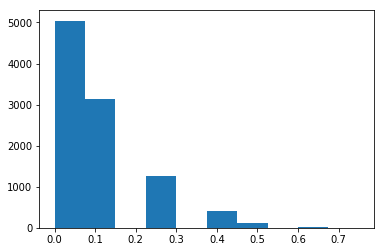

In [38]:
print(len(y_predict_test[:,1][y_predict_test[:,1]>.25])/len(y_predict_test))

plt.hist(y_predict_test[:,1])
plt.show()



In [39]:
new_df_target = [lambda x:1 if x >.15 else 0]
new_target = pd.DataFrame(y_predict_test[:,1]).apply(new_df_target)
print(new_target.iloc[:,0].value_counts())


0    8186
1    1814
Name: (0, <lambda>), dtype: int64


In [40]:
auc_test = metrics.roc_auc_score(y_test, new_target.values)
auc_test

0.5945376521986402

# Convert Dataframe into Pickle File for further Exploration

In [41]:
#df_feateliminated.info()

In [42]:
df_feateliminated.to_pickle('df_pickle.pkl')

NameError: name 'df_feateliminated' is not defined